In [1]:
#Notebook do prezentacji

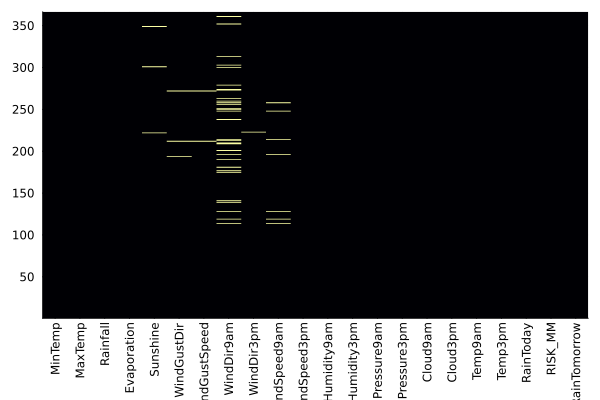

In [1]:
using DataFrames
using CSV
using StatsPlots

weather_data = DataFrame(CSV.File("weather.csv", normalizenames=true, delim=",", missingstring="NA"))
missingvals = ismissing.(weather_data)
@df missingvals heatmap(cols(),xrotation=90,xticks=(1:length(names(missingvals)),names(missingvals)),colorbar=false,)

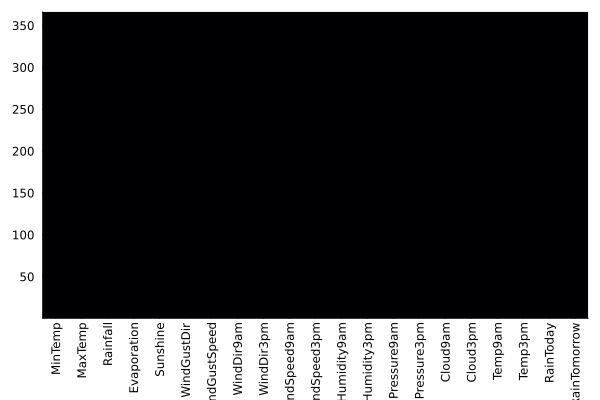

In [19]:
using Statistics
using Impute: Impute
using Random
using Distances
using ScikitLearn
@sk_import preprocessing: (LabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder)

Impute.srs!(weather_data; rng=MersenneTwister(1234))

missingvals = ismissing.(weather_data)
@df missingvals heatmap(cols(),xrotation=90,xticks=(1:length(names(missingvals)),names(missingvals)),colorbar=false,)

In [20]:
first(weather_data)

Row,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
,Float64,Float64,Float64,Float64,Float64?,String3?,Int64?,String3?,String3?,Int64?,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Float64,String3,String3
1,8.0,24.3,0.0,3.4,6.3,NW,30,SW,NW,6,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No,Yes


In [21]:
describe(weather_data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,MinTemp,7.26557,-5.3,7.45,20.9,0,Float64
2,MaxTemp,20.5503,7.6,19.65,35.8,0,Float64
3,Rainfall,1.42842,0.0,0.0,39.8,0,Float64
4,Evaporation,4.52186,0.2,4.2,13.8,0,Float64
5,Sunshine,7.91393,0.0,8.6,13.6,0,"Union{Missing, Float64}"
6,WindGustDir,,E,,WSW,0,"Union{Missing, String3}"
7,WindGustSpeed,39.8497,13,39.0,98,0,"Union{Missing, Int64}"
8,WindDir9am,,E,,WSW,0,"Union{Missing, String3}"
9,WindDir3pm,,E,,WSW,0,"Union{Missing, String3}"


In [2]:
select!(weather_data, Not(:RISK_MM))

Row,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
,Float64,Float64,Float64,Float64,Float64?,String3?,Int64?,String3?,String3?,Int64?,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Float64,String3,String3
1,8.0,24.3,0.0,3.4,6.3,NW,30,SW,NW,6,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No,Yes
2,14.0,26.9,3.6,4.4,9.7,ENE,39,E,W,4,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes,Yes
3,13.7,23.4,3.6,5.8,3.3,NW,85,N,NNE,6,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes,Yes
4,13.3,15.5,39.8,7.2,9.1,NW,54,WNW,W,30,24,62,56,1005.5,1007.0,2,7,13.5,14.1,Yes,Yes
5,7.6,16.1,2.8,5.6,10.6,SSE,50,SSE,ESE,20,28,68,49,1018.3,1018.5,7,7,11.1,15.4,Yes,No
6,6.2,16.9,0.0,5.8,8.2,SE,44,SE,E,20,24,70,57,1023.8,1021.7,7,5,10.9,14.8,No,No
7,6.1,18.2,0.2,4.2,8.4,SE,43,SE,ESE,19,26,63,47,1024.6,1022.2,4,6,12.4,17.3,No,No
8,8.3,17.0,0.0,5.6,4.6,E,41,SE,E,11,24,65,57,1026.2,1024.2,6,7,12.1,15.5,No,No
9,8.8,19.5,0.0,4.0,4.1,S,48,E,ENE,19,17,70,48,1026.1,1022.7,7,7,14.1,18.9,No,Yes


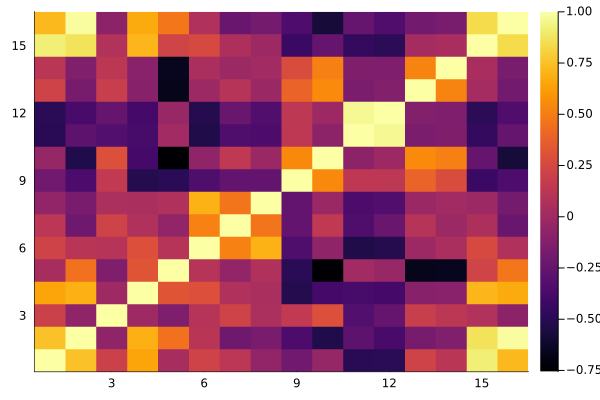

In [24]:
weather_corr = select(weather_data, Not([:WindGustDir, :WindDir9am, :WindDir3pm, :RainToday, :RainTomorrow]))

cm = pairwise(cor, eachcol(weather_corr))
heatmap(cm)

## Wykres pokazujący relację między temp. o 9 i min. temp.

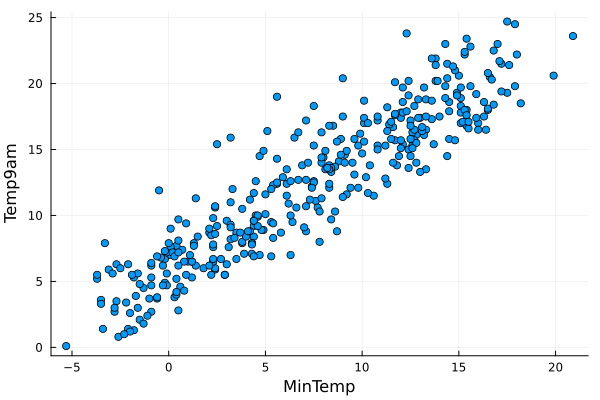

In [3]:
scatter(weather_data.MinTemp, weather_data.Temp9am, xlabel="MinTemp",ylabel="Temp9am", label="")

## Wykres pokazujący relację między temp. o 15 i max. temp.

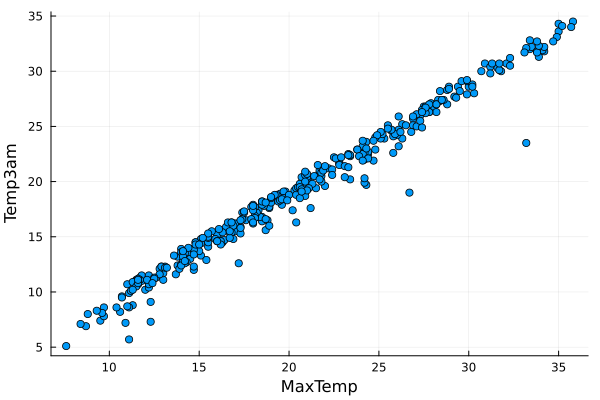

In [4]:
scatter(weather_data.MaxTemp, weather_data.Temp3pm, xlabel="MaxTemp", ylabel="Temp3am", label="")

## Wykres nasłonecznienia od temperatury o godz. 15.00

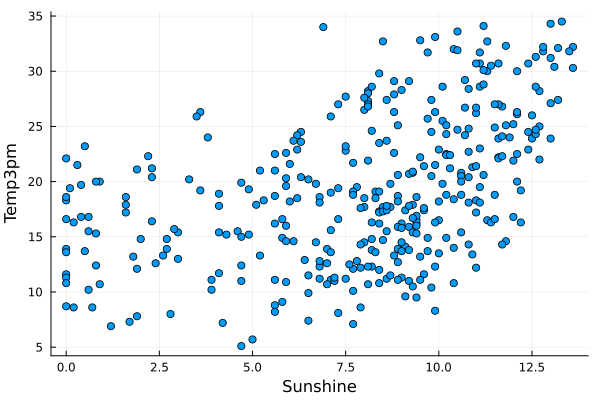

In [5]:
scatter(weather_data.Sunshine, weather_data.Temp3pm, xlabel="Sunshine", ylabel="Temp3pm", label="")

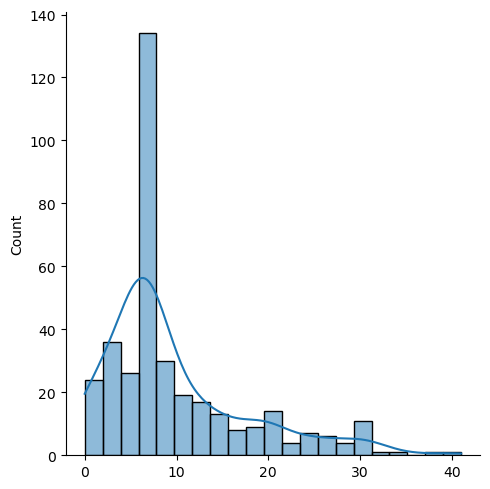

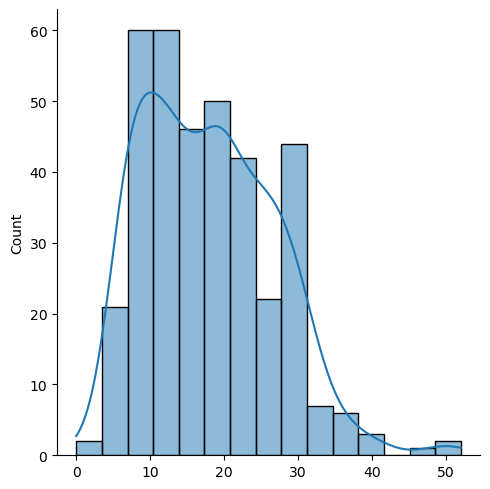

PyObject <seaborn.axisgrid.FacetGrid object at 0x2caec5960>

In [9]:
using Seaborn
Seaborn.displot(weather_data.WindSpeed9am, kde=true)
Seaborn.displot(weather_data.WindSpeed3pm, kde=true)

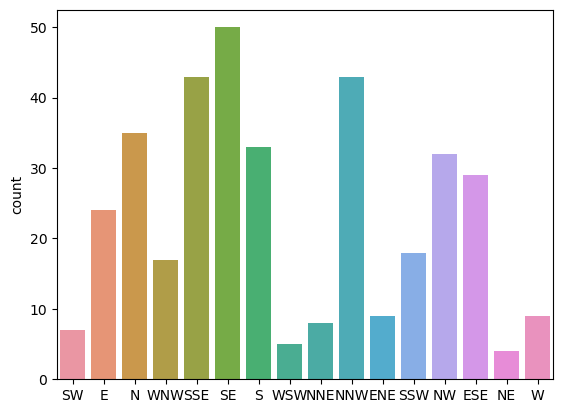

PyObject <Axes: ylabel='count'>

In [73]:
Seaborn.countplot(x=weather_data.WindDir9am)

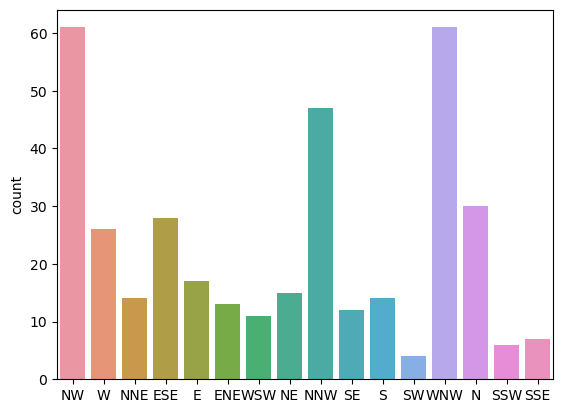

PyObject <Axes: ylabel='count'>

In [10]:
Seaborn.countplot(x=weather_data.WindDir3pm)

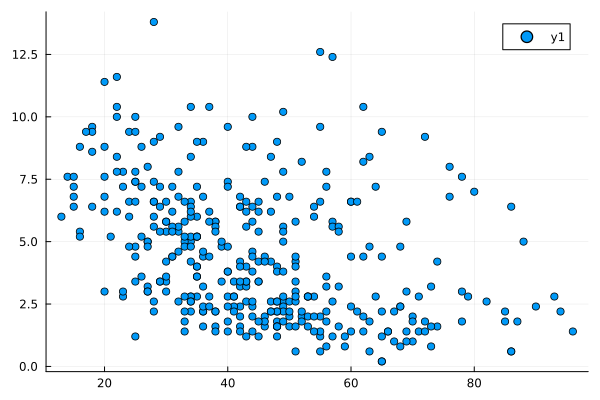

In [11]:
scatter(weather_data.Humidity3pm,weather_data.Evaporation)

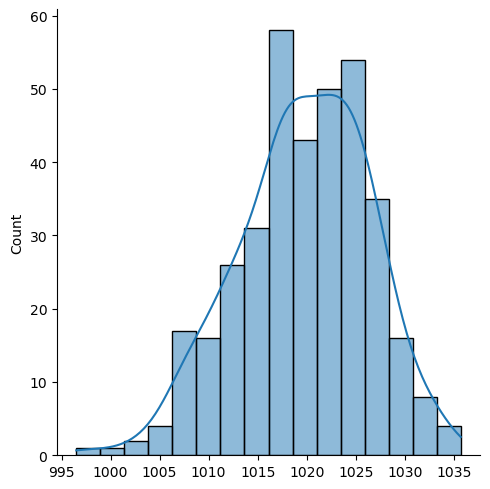

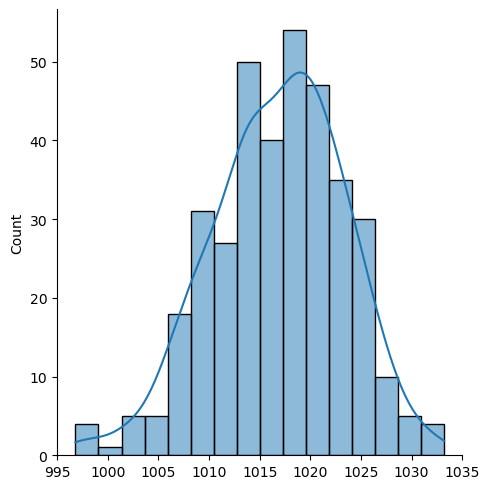

PyObject <seaborn.axisgrid.FacetGrid object at 0x2cb7b7640>

In [12]:
Seaborn.displot(weather_data.Pressure9am, kde=true)
Seaborn.displot(weather_data.Pressure3pm, kde=true)

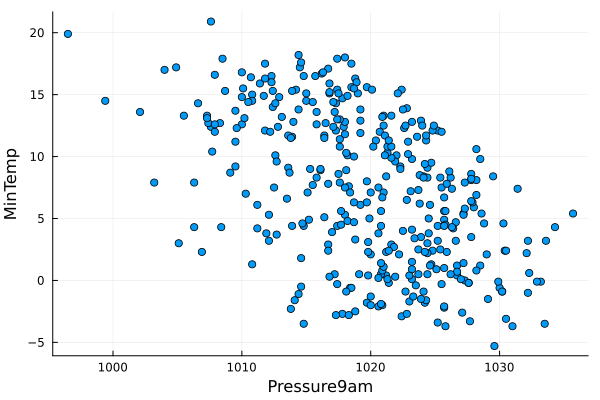

In [13]:
scatter(weather_data.Pressure9am, weather_data.MinTemp, label="", xlabel="Pressure9am", ylabel="MinTemp")

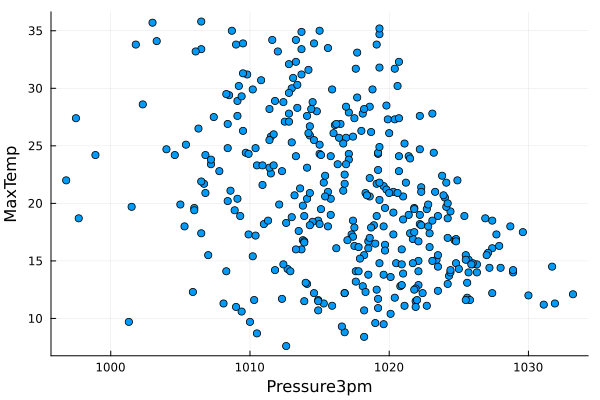

In [14]:
scatter(weather_data.Pressure3pm, weather_data.MaxTemp, label="", xlabel="Pressure3pm", ylabel="MaxTemp")

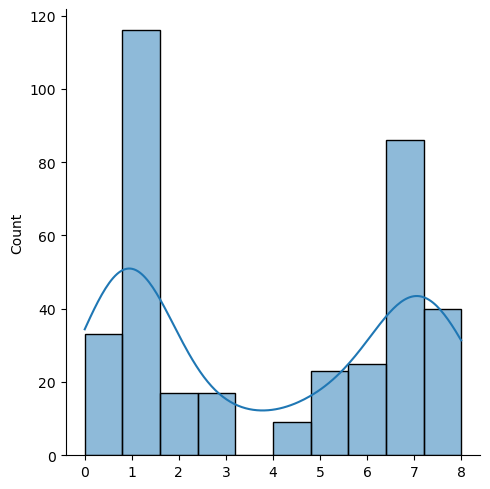

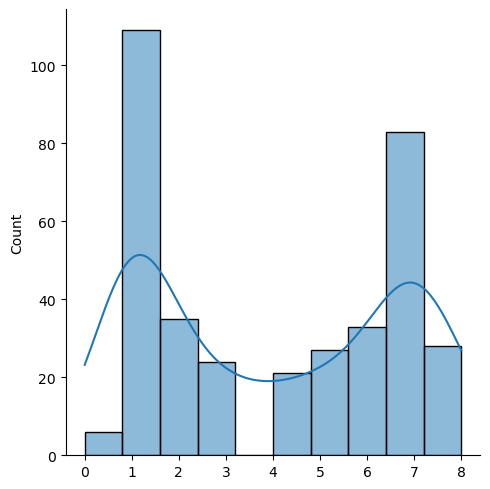

PyObject <seaborn.axisgrid.FacetGrid object at 0x2cd65d4b0>

In [15]:
Seaborn.displot(weather_data.Cloud9am, kde=true)
Seaborn.displot(weather_data.Cloud3pm, kde=true)

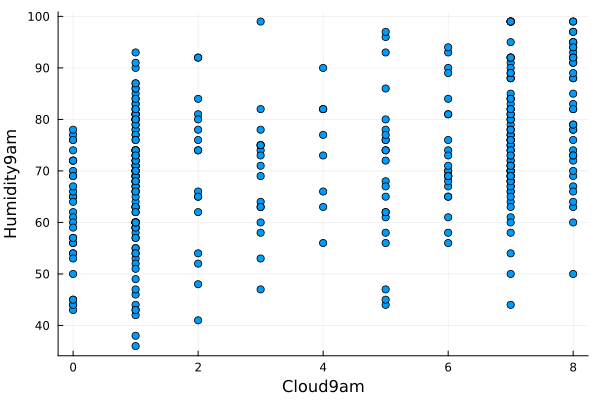

In [16]:
scatter(weather_data.Cloud9am, weather_data.Humidity9am, label="", xlabel="Cloud9am", ylabel="Humidity9am")

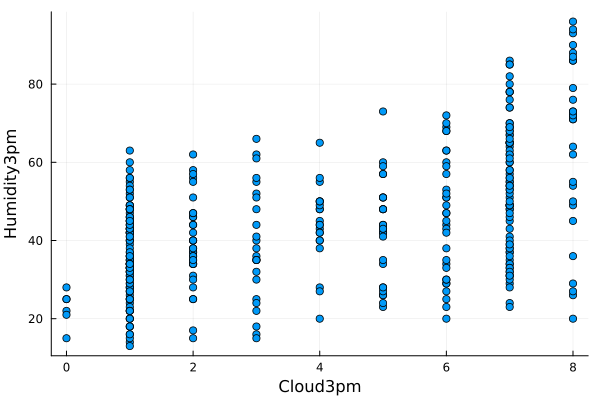

In [17]:
scatter(weather_data.Cloud3pm, weather_data.Humidity3pm, label="", xlabel="Cloud3pm", ylabel="Humidity3pm")

In [95]:
mapper2 = DataFrameMapper([([:MinTemp], StandardScaler()),
([:MaxTemp], StandardScaler()),
([:Rainfall], StandardScaler()),
([:Evaporation], StandardScaler()),
([:Sunshine], StandardScaler()),
([:WindSpeed9am], StandardScaler()),
([:WindSpeed3pm], StandardScaler()),
([:Humidity9am], StandardScaler()),
([:Humidity3pm], StandardScaler()),
([:Pressure9am], StandardScaler()),
([:Pressure3pm], StandardScaler()),
([:Cloud9am], StandardScaler()),
([:Cloud3pm], StandardScaler()),
([:Temp9am], StandardScaler()),
([:Temp3pm], StandardScaler()),
(:WindGustDir, LabelBinarizer()),
([:WindGustSpeed], StandardScaler()),
(:WindDir9am, LabelBinarizer()),
(:WindDir3pm, LabelBinarizer()),
([:WindSpeed9am], StandardScaler()),
([:WindSpeed3pm], StandardScaler()),
([:Humidity9am], StandardScaler()),
([:Humidity3pm], StandardScaler()),
([:Pressure9am], StandardScaler()),
([:Pressure3pm], StandardScaler()),
([:Cloud9am], StandardScaler()),
([:Cloud3pm], StandardScaler()),
([:Temp9am], StandardScaler()),
([:Temp3pm], StandardScaler()),
(:RainToday, LabelBinarizer()),
(:RainTomorrow, LabelBinarizer())]
)


data_matrix = fit_transform!(mapper2, copy(weather_data))

366×76 Matrix{Float64}:
  0.122047    0.561221   -0.338485  …   0.363059     0.658867   0.0  1.0
  1.11913     0.950363    0.514591      0.914353     0.975549   1.0  1.0
  1.06927     0.426518    0.514591      0.540896     0.146145   1.0  1.0
  1.0028     -0.755874    9.09274       0.203006    -0.77374    1.0  1.0
  0.055575   -0.666072    0.325018     -0.223802    -0.577699   1.0  0.0
 -0.177077   -0.546336   -0.338485  …  -0.25937     -0.668179   0.0  0.0
 -0.193695   -0.351765   -0.291092      0.00738557  -0.291177   0.0  0.0
  0.171901   -0.531369   -0.338485     -0.0459655   -0.562619   0.0  0.0
  0.254991   -0.157194   -0.338485      0.309708    -0.0498961  0.0  1.0
  0.188519    0.336716    3.50036       0.167439     0.372346   1.0  0.0
  0.304845    0.695924   -0.338485  …   0.398626     0.719188   0.0  0.0
  0.205137    1.01023    -0.291092      0.789867     1.02079    0.0  0.0
  0.471026    1.10003    -0.338485      0.825435     1.18667    0.0  0.0
  ⋮                        